# Lab 6: Locally Linear Embedding  

In this tutorial, you will learn the following

* What Locally Linear Embedding (LLE) is
* How we formulate the problem of LLE
* How we compute the similarity matrix
* How we reduce dimensionality of original dataset through weight matrix
* How we generate a swiss-roll dataset
* How we use LLE to visualize a dataset

To do the exercise, you need to fill in some code below. Suggested solutions will be posted on Canvas later.

## What is LLE and how we formulate this problem

LLE is an unsupervised dimensionality reduction method and a manifold learning algorithm that uses local linearity to reflect global nonlinearity. Specifically, it reduces the dimensionality of data by keeping local topological structures of the original data. It has three steps:

**First**, it construct a K-nearest neighbor graph from the original dataset $X=[\boldsymbol{x}_1,...,\boldsymbol{x}_n]\in \mathbb{R}^{d\times n}$ using Euclidean distance. 

**Second**, for each data point $\boldsymbol{x}_i$ in $X$, LLE needs to minimise the following problem:
<!-- it computes the weight matrix $W_{i,j}$ between the $i$th point and $j$th data point: -->

$$W = \min_{W_{ij}} \sum_{i=1}^{n}|\boldsymbol{x}_i-\sum_{j=1}^{k}W_{ij}\boldsymbol{x}_{{\cal N}_i(j)}|^2$$
$$\text{s.t.} \sum_{j}^{k}W_{ij}=1$$

where $W_{ij}$ represents the local linear relation between $\boldsymbol{x}_i$ and its neighbors $\boldsymbol{x}_{{\cal N}_i(j)}$ and ${\cal N}_{i}(j)$ represent the index of the $j$-th neighbor of $\boldsymbol{x}_i$.

**Third**, we project the original dataset $X\in \mathbb{R}^{d\times n}$ to $Y = [\boldsymbol{y}_1,...,\boldsymbol{y}_n] \in \mathbb{R}^{p\times n}$ by keeping local linear relation $W$ of the original dataset:

$$Y = \min_{Y} \sum_{i=1}^{n}|\boldsymbol{y}_i-\sum_{j=1}^{n}W_{ij}\boldsymbol{y}_{{\cal N}_i(j)}|^2$$
$$\text{s.t.}  YY^T=I \;\text{and}\; \sum_{j=1}^{n} \boldsymbol{y_i} = 0 $$

By minimising this problem, we would like data points in the low-dimensional space ($Y$) to retain the local relation between points in the high-dimensional space ($X$). For the two constraints, the first one (similar to that in direct PCA) guarantees a solution to this problem and the second one makes sure the projected data has a zero mean. The second constraint has a same effect as the two steps in PCA, where we first centralise original data and then project the centralised data.


## Minimising two objective functions in LLE

### How to compute the weight matrix $W$

To minimise the first objective function in LLE, we define a matrix ${\cal N}_i=[\boldsymbol{x}_{{\cal N}_{i}(1)},\boldsymbol{x}_{{\cal N}_{i}(2)},\cdots,\boldsymbol{x}_{{\cal N}_{i}(k)}]\in \mathbb{R}^{d\times k}$ that consists of $k$-nearest neighbor points. We then construct the Gramm matrix $G_{i}$, which is calculated by the matrix ${\cal N}_i$ and $\boldsymbol{x}_i$:

$$G_i = (\boldsymbol{x}_i \boldsymbol{e}^T-{\cal N}_i)^T(\boldsymbol{x}_i \boldsymbol{e}^T-{\cal N}_i)$$ 

where $\boldsymbol{e}^T = [1,...,1] \in \mathbb{R}^{1\times k}$, $\boldsymbol{x}_i \boldsymbol{e}^T = [\boldsymbol{x}_i,...,\boldsymbol{x}_i] \in \mathbb{R}^{d\times k}$ and $G_i \in \mathbb{R}^{k\times k}$. Then we calculate the similarity matrix $\boldsymbol{w}_i$ for the $i$-th data point as follows

$$\boldsymbol{w}_i = \frac{\lambda }{2}G_i^{-1}\boldsymbol{e}$$

Note that $G_i^{-1}$ is not always invertable, therefore we need to add a small diagonal matrix $\epsilon I$ to $G_i$ and then do the matrix inversion

$$\boldsymbol{w}_i = \frac{\lambda }{2}(G_i+\epsilon I)^{-1}\boldsymbol{e}$$

To solve the equation, we need to define a positive value for $\lambda$ and then use this $\lambda$ to compute $\boldsymbol{w}_i$. We then need to normalise $\boldsymbol{w}_i$ such that the sum of all elements in $\boldsymbol{w}_i$ is 1. Finally, we assemble $W = [\boldsymbol{w}_1,\boldsymbol{w}_2,\cdots,\boldsymbol{w}_{\text{n}}] \in  \mathbb{R}^{k\times n}$.

### How to reduce dimensionality of original dataset to $Y$ using the weight matrix $W$
To find a solution to the second contrained minimisation problem, we need to construct the matrix 

$$M = (I-W)(I-W)^T$$

We then do eigen-decomposition on $M \in \mathbb{R}^{n\times n}$ to find all eigenvectors and eignvalues. These eigenvectors are then sorted using their eigenvalues in an ascending order, meaning that the first eigenvector correponds to the smallest eigenvalue, the second eigenvector correponds to the second smallest eigenvalue, etc. The solution $Y$ is then the top 2 to $p+1$ eigenvectors of $M$, where .
$$Y=\begin{bmatrix}
\boldsymbol{eig}_2^T \\
\boldsymbol{eig}_3^T  \\
\vdots \\
\boldsymbol{eig}_{p+1}^T\\
\end{bmatrix},$$
where $Y \in \mathbb{R}^{p\times n} $, $p$ is the number of reduced dimension and $\boldsymbol{eig}_i$ denotes the $i$th eigenvector of $M$. The reason that we discard the eigenvector associated with eigenvalue 0 satisfies the constraint $\sum_{j=1}^{n} \boldsymbol{y_i} = 0$. Lets implement these maths by going through a specific examples below. First, we need to create a dataset, which is a swiss roll dataset built in `sklearn datasets`

In [1]:
from sklearn import datasets
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

X, label = datasets.make_swiss_roll(n_samples=2000, random_state=0)
X = X.T
print(X.shape)

/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/feature_extraction/image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):


(3, 2000)


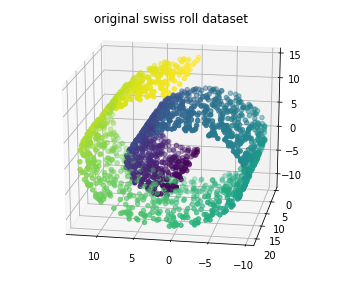

In [2]:
# plot original swiss roll data
fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(1, 3, 1 , projection='3d')
ax1.scatter(X[0,:], X[1,:], X[2,:], c = label)
ax1.view_init(20, 100)
ax1.set_title("original swiss roll dataset")

plt.show()

In [3]:
def distance_matrix(X):
    dim,num = X.shape
    D = np.zeros([num,num],np.float32)
    for i in range(num):
        for j in range(num):
            #############################################################
            # write your code here to compute the pair-wise distance D[i,j]
            #############################################################
    return D

we establish a Euclidean distance function `distance_matrix` in order to define a k-nearest neighbor graph.
* `np.max`: a function to solve the maximum value 
* `np.argsort`: a sort function that could observe the index of the ranked array (from min to max)

In [4]:
def k_nearest_neighbors(data, k = 10):
    '''
    :param data: (n_features, data_numbers)
    :param n_neighbors: n nearest neighbors
    :return: neighbors indexs
    '''
    D = distance_matrix(data) # compute pairwise distance matrix D
    n = data.shape[1] # number of data points in the dataset
    N = np.zeros((n, k), dtype='int32') # N has n rows, each row saving indices if k-nearest points 
    for i in range(n):
        sorted_ind = np.argsort(D[i,:]) # for each data point, sort its Euclidean distances to all other points in the dataset in a descending order
        ind = sorted_ind[1:k+1] # select the first k-nearest points (excluding itself) and return their indices
        N[i] = N[i] + ind # save the indices of k-nearest points 

    return N

In the first step of LLE, we need to construct a $k$-nearest neighbor graph from the original dataset $X=[\boldsymbol{x}_1,...,\boldsymbol{x}_n]\in \mathbb{R}^{d\times n}$ using Euclidean distance. `k_nearest_neighbors` above does this. It takes data and the number of $k$-nearest points as inputs and return a matrix $N$ of size $n\times k$, for which $N[i]$ saves the indices of the $k$-nearest data points of the $i$-th data point. For example, if we call `N = k_nearest_neighbors(X, 5)` below, the result will be `[1749 1634 230 324 213]`. This means the points $1749$, $1634$, $230$, $324$ and $213$ are $5$-nearest data points of the $31$-th data point in the dataset.

In [5]:
N = k_nearest_neighbors(X, 5)
print(N[30])

[1749 1634  230  324  213]


In [6]:
def compute_similarity_matrix(data, N):
    '''
    :param data: original data X of (d_dims, n_samples)
    :param k: k nearest neighbhors
    :return similarity: (n_samples, n_samples)
    '''
    d, n = data.shape # get data size (d_dims, n_samples)
    k = len(N[1]) # k-nearest points
    e = np.ones((k,1),np.float32) # e has the size (k, 1), and all entries are 1.
    W = np.zeros((n, n)) # W[:,i] denotes similarities bwteen point i and its k-nearest points
    eps = 1e-2 # small value eps added to diagonal entries of Gi to make it invertable
    
    for i in range(n):
        xi = np.reshape(data[:,i], [d,1]) # retrieve data point xi of size d by 1
        xiet = np.dot(xi, e.T) # xi multipled by e tranpose
        Ni = data[:,N[i]] # retrieve k-nearest points of xi and save them to Ni of size d by k
        Gi = np.dot((xiet - Ni).T, (xiet - Ni)) # compute (xie^T - Ni)T(xie^T - Ni)
        Gi = Gi + eps*np.eye(k) # compute Gi+epsI, where I is a identiy matrix
        inv_Gi = np.linalg.inv(Gi) # compute inverse of Gi+epsI
        wi = np.dot(inv_Gi, e) # compute (Gi+epsI)^-1e with lambda equal to 2
        #############################################################
        # write your code here to normalise wi (one line code)
        #############################################################
        W[N[i],i] = wi[:,0] # save wi as one column of the similarity matrix W. For the column, only the indices where k-nearest points should have values.
        
    return W

Above, we write a function `compute_similarity_matrix(data, N)` to do the second step in LLE. The function takes the original dataset $X$ and $k$-nearest neighbor graph $N$ from the first step as inputs. First we recall that to minimise the first objective function in LLE, we need to compute the Gram matrix $G_i$

$$G_i = (\boldsymbol{x}_i \boldsymbol{e}^T-{\cal N}_i)^T(\boldsymbol{x}_i \boldsymbol{e}^T-{\cal N}_i)$$ 

where $\boldsymbol{x}_i \in \mathbb{R}^{d \times 1}$ is the $i$-th data point in the dataset, $\boldsymbol{e} = [1,...,1]^T \in \mathbb{R}^{ k \times 1}$ is a vector consists $k$ ones and ${\cal N}_i=[\boldsymbol{x}_{{\cal N}_{i}(1)},\boldsymbol{x}_{{\cal N}_{i}(2)},\cdots,\boldsymbol{x}_{{\cal N}_{i}(k)}]\in \mathbb{R}^{d\times k}$ denotes $k$-nearest data points of $\boldsymbol{x}_i$

Then, the similarity matrix for the $i$-th data point is given by  
$$\boldsymbol{w}_i = \frac{\lambda }{2}(G_i+\xi I)^{-1}\boldsymbol{e}$$

To solve the equation, we need to define a positive value for $\lambda$ and then use this $\lambda$ to compute $\boldsymbol{w}_i$. We then need to normalise $\boldsymbol{w}_i$ such that the sum of all elements in $\boldsymbol{w}_i$ is 1. Finally, we assemble the similarity matrix $W \in  \mathbb{R}^{n\times n}$, where $W[{\cal N}_i,i] = \boldsymbol{w}_i$.


In [7]:
def project_data(W, p = 2):
    '''
    :param similarity W: (n_samples, n_samples)
    :return projected data: (p_dims, n_samples)
    '''
    n, _ = W.shape # get the number of data points n
    I = np.eye(n)  # construst a identity matrix I 
    ##################################################################################
    # write your code here to compute M = (I-W)(I-W)^T (one line code)
    ##################################################################################
    
    ##################################################################################
    # write your code here to compute eigenvectors of M using SVD (one line code)
    ##################################################################################
    U_p = U[:,-(p+1):-1] # select bottom p eigenvectors excluding the one associated with zero egienvalue
    U_p = U_p[:,::-1] # reverse the order od eigenvectors such that the first one is the samllest one, the second one is second samllest one, etc. 
    Y = U_p.T # tranpose these eigenvectors to make sure the size of projected data is p by n
    
    return Y

The third step in LLE is to project (embed) the dataset such that the dimension of the dataset can be reduced for visualisatoin. To do this, we need to construct the matrix 

$$M = (I-W)(I-W)^T$$

We then do eigen-decomposition on $M \in \mathbb{R}^{n\times n}$ to find all eigenvectors and eignvalues. These eigenvectors are then sorted using their eigenvalues in an ascending order. The projected dataset $Y$ then consists of the top 2 to $p+1$ eigenvectors of $M$
$$Y=\begin{bmatrix}
\boldsymbol{eig}_2^T \\
\boldsymbol{eig}_3^T  \\
\vdots \\
\boldsymbol{eig}_{p+1}^T\\
\end{bmatrix},$$
where $Y \in \mathbb{R}^{p\times n} $, $p$ is the number of reduced dimension and $\boldsymbol{eig}_i$ denotes the $i$th eigenvector of $M$. The reason that we discard the eigenvector associated with eigenvalue 0 satisfies the constraint $\sum_{j=1}^{n} \boldsymbol{y_i} = 0$. Lastly, we combine all three steps to make the full algorithm of LLE, which is given below. Note that it takes a while to finish these steps, so be patient.  

In [8]:
N = k_nearest_neighbors(X, k=10) # step 1: build k-nearest (k=10) neighbour graph
W = compute_similarity_matrix(X, N) # step 2: compute similarity matrix W
Y = project_data(W, p=2) # step 3: project data X to Y using W

In [9]:
print(np.sum(Y, axis=1)) 

[-2.22618622e-05  7.44923660e-08]


As you can see that if we compute the mean vector of $Y$, we end up with a vector with very small values which means the constraint $\sum_{j=1}^{n} \boldsymbol{y_i} = 0$ is met. To better illstruate the advantage of LLE, we use PCA to project data below. 

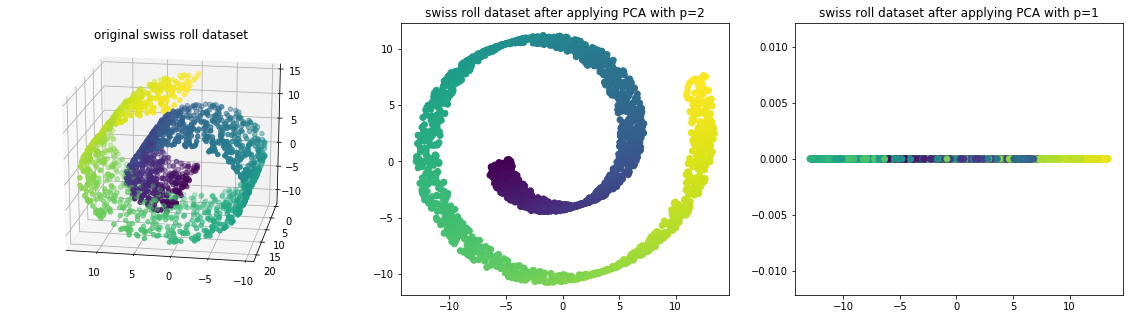

In [12]:
from sklearn.decomposition import PCA
sklearn_pca = PCA(n_components=2)
# This PCA requires data of n by d, where n is number of samples and d is data dimenion
PCA = sklearn_pca.fit_transform(X.T) 
fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(1, 3, 1 , projection='3d')
ax1.scatter(X[0,:], X[1,:], X[2,:], c = label)
ax1.view_init(20, 100)
ax1.set_title("original swiss roll dataset")

ax2 = fig.add_subplot(1, 3, 2)
ax2.scatter(PCA[:, 0], PCA[:, 1], c = label)
ax2.set_title("swiss roll dataset after applying PCA with p=2")

y_axis = np.zeros(2000)
ax3 = fig.add_subplot(133)
ax3.scatter(PCA[:, 0], y_axis, c = label)
ax3.set_title("swiss roll dataset after applying PCA with p=1")
plt.show()

Then, we project data using different choices of $k$, as can be seen from the following figures, If $k$ is too small (1st row) or too large (last row), LLE cannot succeed in unraveling the manifold and recovering the two underlying degrees of freedom. Note that, running the following code is slow and will take a few minutes. 

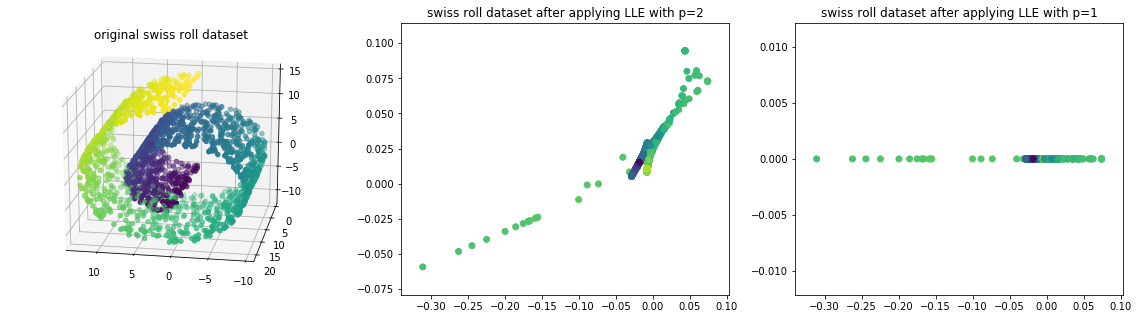

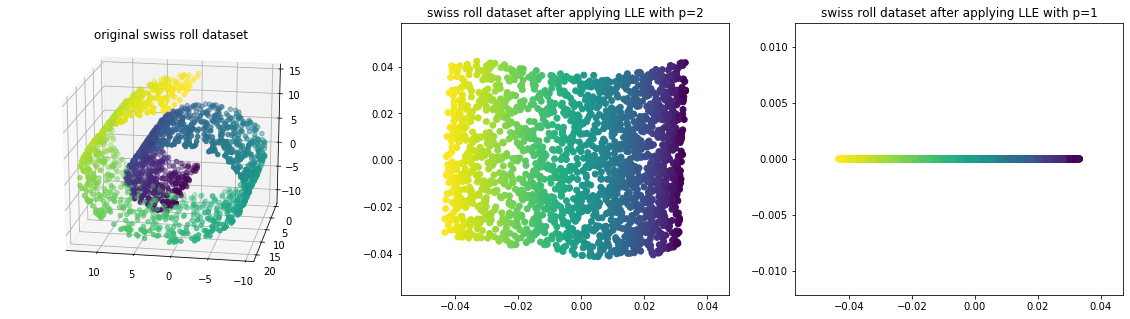

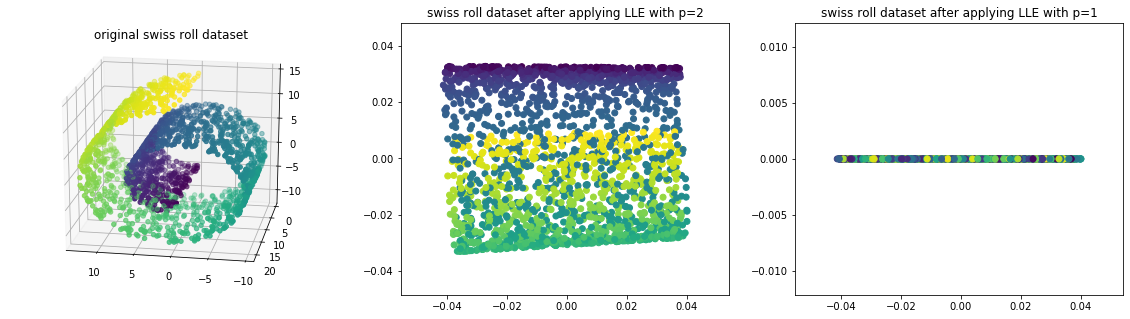

In [11]:
for k in [5,14,40]:
    
    N = k_nearest_neighbors(X, k) 
    W = compute_similarity_matrix(X, N)
    Y = project_data(W, p=2)

    fig = plt.figure(figsize=(20, 5))
    ax1 = fig.add_subplot(1, 3, 1 , projection='3d')
    ax1.scatter(X[0,:], X[1,:], X[2,:], c = label)
    ax1.view_init(20, 100)
    ax1.set_title("original swiss roll dataset")

    ax2 = fig.add_subplot(1, 3, 2)
    ax2.scatter(Y[0, :], Y[1, :], c = label)
    ax2.set_title("swiss roll dataset after applying LLE with p=2")

    y_axis = np.zeros(2000)
    ax3 = fig.add_subplot(133)
    ax3.scatter(Y[0, :], y_axis, c = label)
    ax3.set_title("swiss roll dataset after applying LLE with p=1")

    plt.show()

As you can see, we use `plt.scatter` to show data points and their labels (component `c`).

* `plt.subplot`: a plot function could show established sub-figures.
* `plt.scatter`: a plot function whose inputs are every dimension of the dataset we want to show and their labels.
* `plt.title`: a function to name your figure.
* `plt.figure`: a function to create a figure.